In [1]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import umap

### Declare helper functions

In [2]:
# Helper Function to plot confusion Matrix
def plot_confusion_matrix(confusion_matrix, kernel: str, y_limit: list, color_map: str):
    #Plot the confusion Matrix
    fig, ax = plt.subplots(figsize=(10,6))
    title = f'Confusion matrix - SVM - {kernel.upper()}'
    # create heatmap
    sns.heatmap(confusion_matrix, annot = True, cmap = color_map ,fmt='g')
    ax.xaxis.set_label_position("top")
    ax.set_ylim(y_limit)
    ax.xaxis.set_ticklabels(['2','4'])
    ax.yaxis.set_ticklabels(['2','4'])
    plt.title(title, fontsize=20, pad=10.0)
    plt.ylabel('Actual label', fontsize='large')
    plt.xlabel('Predicted label', fontsize='large')
    plt.tight_layout()

In [3]:
# Train and Test Classifier
# Imput datasets as a list in the folowing format: [X_train,  y_train, X_test, y_test]
def test_classifier(kernel: str, datasets: list):
    
    # Instantiate the classifier
    classifier = SVC(kernel = kernel)
    
    start = time.perf_counter()
    # Fit the classifier to the data
    classifier.fit(datasets[0], datasets[1])
    end = time.perf_counter()
    print('-' * 115)
    print()
    # Print the time taken to train the models
    print(f'{kernel.upper()} processing time: {round((end-start), 6)} s')
    
    # Print Accuracy score on the TRAINING set
    print()
    print('-' * 115)
    print()
    print(f'{kernel.upper()} Training Accuracy score:  {np.round(classifier.score(datasets[0], datasets[1]), 6) * 100}%')
    print()
    # Print Accuracy score on the TEST set
    print(f'{kernel.upper()} Test Accuracy score: {np.round(classifier.score(datasets[2], datasets[3]), 6) * 100}%')   
    print()
    
    # Make pedictions
    y_pred = classifier.predict(datasets[2])
    
    # Get the Confusion Matrix
    cm = confusion_matrix(datasets[-1], y_pred)

    print()
    # Plot the Confusion Matrix
    color_maps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
    random_index = np.random.randint(0, 4, 1)

    # Call the Confusion Matrix function
    plot_confusion_matrix(cm, kernel, [0, 2], color_maps[random_index[0]])
    
    # Print Classification Report
    print('\t\tClassification Report\n\n',classification_report(datasets[-1], y_pred))

<div align="center" style='font-size:40px; padding:20px 0px'><strong> EXERCISE 1 </strong></div>

In [4]:
# Load the dataset
data_bruno = pd.read_csv('breast_cancer.csv')

In [5]:
# Get the head of the dataset to have an initial view of its components
data_bruno.head()

,ID,thickness,size,shape,Marg,Epith,bare,b1,nucleoli,Mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [6]:
# List of columns
data_bruno.columns

Index(['ID', 'thickness', 'size', 'shape', 'Marg', 'Epith', 'bare', 'b1',
       'nucleoli', 'Mitoses', 'class'],
      dtype='object')

In [7]:
# Get information about the structure and types of the dataset
data_bruno.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         699 non-null    int64 
 1   thickness  699 non-null    int64 
 2   size       699 non-null    int64 
 3   shape      699 non-null    int64 
 4   Marg       699 non-null    int64 
 5   Epith      699 non-null    int64 
 6   bare       699 non-null    object
 7   b1         699 non-null    int64 
 8   nucleoli   699 non-null    int64 
 9   Mitoses    699 non-null    int64 
 10  class      699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


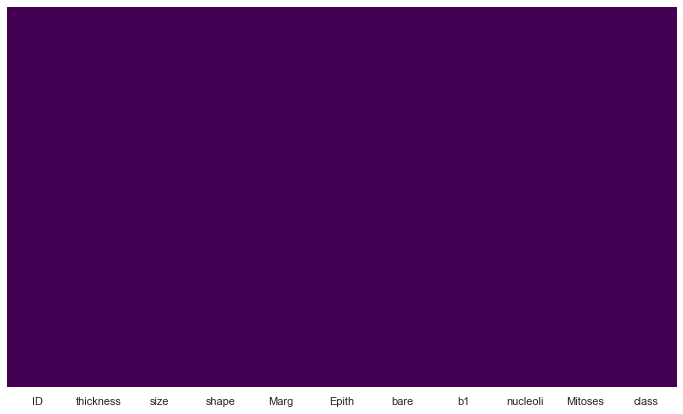

In [8]:
#Use a heatmap to visualize missing data
sns.set(rc={"figure.figsize":(12, 7)})
sns.heatmap(data_bruno.isna(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

`No missing data visible in the heatmap`

In [9]:
# Confirm the visual cue that the dataset is integral and that there are no missing data
data_bruno.isnull().sum().sort_values(ascending=False)

ID           0
thickness    0
size         0
shape        0
Marg         0
Epith        0
bare         0
b1           0
nucleoli     0
Mitoses      0
class        0
dtype: int64

In [10]:
# Statistics
data_bruno.describe()

,ID,thickness,size,shape,Marg,Epith,b1,nucleoli,Mitoses,class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [11]:
# A glimpse inside the target variables vector
data_bruno['class']

0      2
1      2
2      2
3      2
4      2
      ..
694    2
695    2
696    4
697    4
698    4
Name: class, Length: 699, dtype: int64

In [12]:
# Remove '?' from 'bare' features column
data_bruno['bare'].replace(to_replace = '?', value = np.nan, inplace = True)

In [13]:
# Convert 'bare' column into float
data_bruno['bare'] = data_bruno['bare'].astype('float')

In [14]:
# Confirm the change to numeric
data_bruno['bare'].dtype

dtype('float64')

In [15]:
# Check the mean of each column in the dataframe
data_bruno[data_bruno.columns].mean().round(2)

ID           1071704.10
thickness          4.42
size               3.13
shape              3.21
Marg               2.81
Epith              3.22
bare               3.54
b1                 3.44
nucleoli           2.87
Mitoses            1.59
class              2.69
dtype: float64

In [16]:
# Replace NaN by the column's mean
data_bruno.fillna(data_bruno.mean(), inplace = True)

In [17]:
# Confirm that there are no more 'NaN'
data_bruno.isna().sum()

ID           0
thickness    0
size         0
shape        0
Marg         0
Epith        0
bare         0
b1           0
nucleoli     0
Mitoses      0
class        0
dtype: int64

In [18]:
# Remove the 'ID' column, since it is simply an index and it does not have statistical significance.
data_bruno.drop('ID', axis = 1, inplace = True)

In [19]:
data_bruno.head()

,thickness,size,shape,Marg,Epith,bare,b1,nucleoli,Mitoses,class
0,5,1,1,1,2,1.0,3,1,1,2
1,5,4,4,5,7,10.0,3,2,1,2
2,3,1,1,1,2,2.0,3,1,1,2
3,6,8,8,1,3,4.0,3,7,1,2
4,4,1,1,3,2,1.0,3,1,1,2


In [20]:
# Get the proportion of the two classess in the target vector
proportion = data_bruno['class'].value_counts()/len(data_bruno['class'])

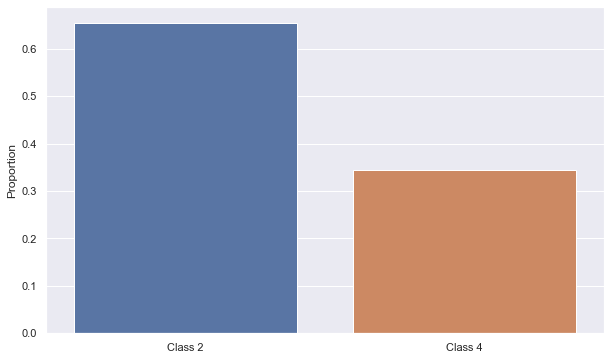

In [21]:
# Check for imbalanced target variables
plt.figure(figsize = (10,6))
sns.barplot(x = [2,4], y = proportion)
plt.xticks(np.arange(2),('Class 2', 'Class 4'))
plt.ylabel('Proportion')
plt.show()

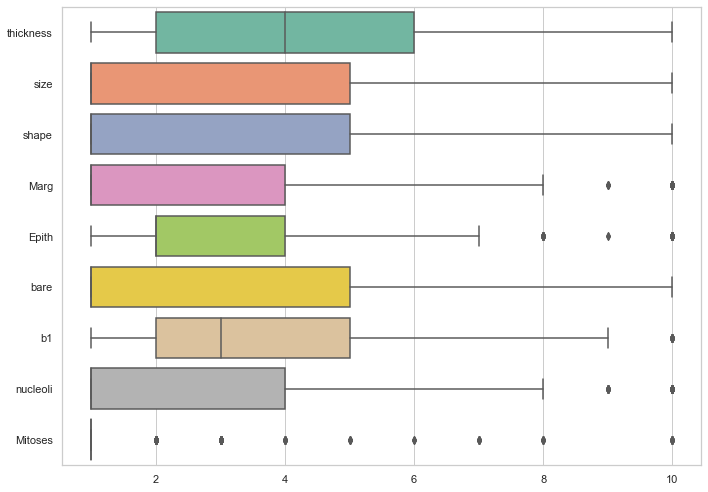

In [22]:
sns.set_style("whitegrid")
figure = plt.figure(figsize=[10,7])
ax = sns.boxplot(data=data_bruno[['thickness', 'size', 'shape', 'Marg', 'Epith', 'bare', 'b1',
       'nucleoli', 'Mitoses']], palette="Set2", orient = 'h')
plt.tight_layout()

In [23]:
data_bruno.iloc[:, 1]

0       1
1       4
2       1
3       8
4       1
       ..
694     1
695     1
696    10
697     8
698     8
Name: size, Length: 699, dtype: int64

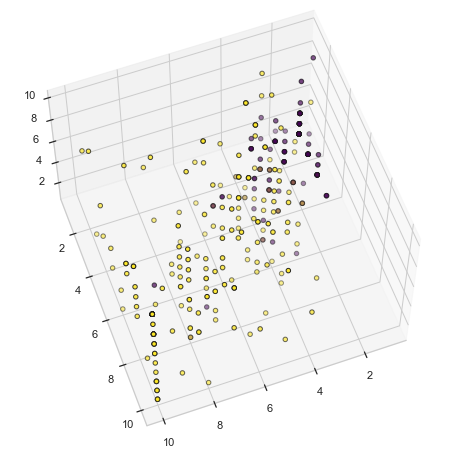

In [24]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(data_bruno.iloc[:, 1], data_bruno.iloc[:, 2], data_bruno.iloc[:, 3], c=data_bruno['class'], edgecolors='k', cmap='viridis')
ax.view_init(60,70)
plt.show()

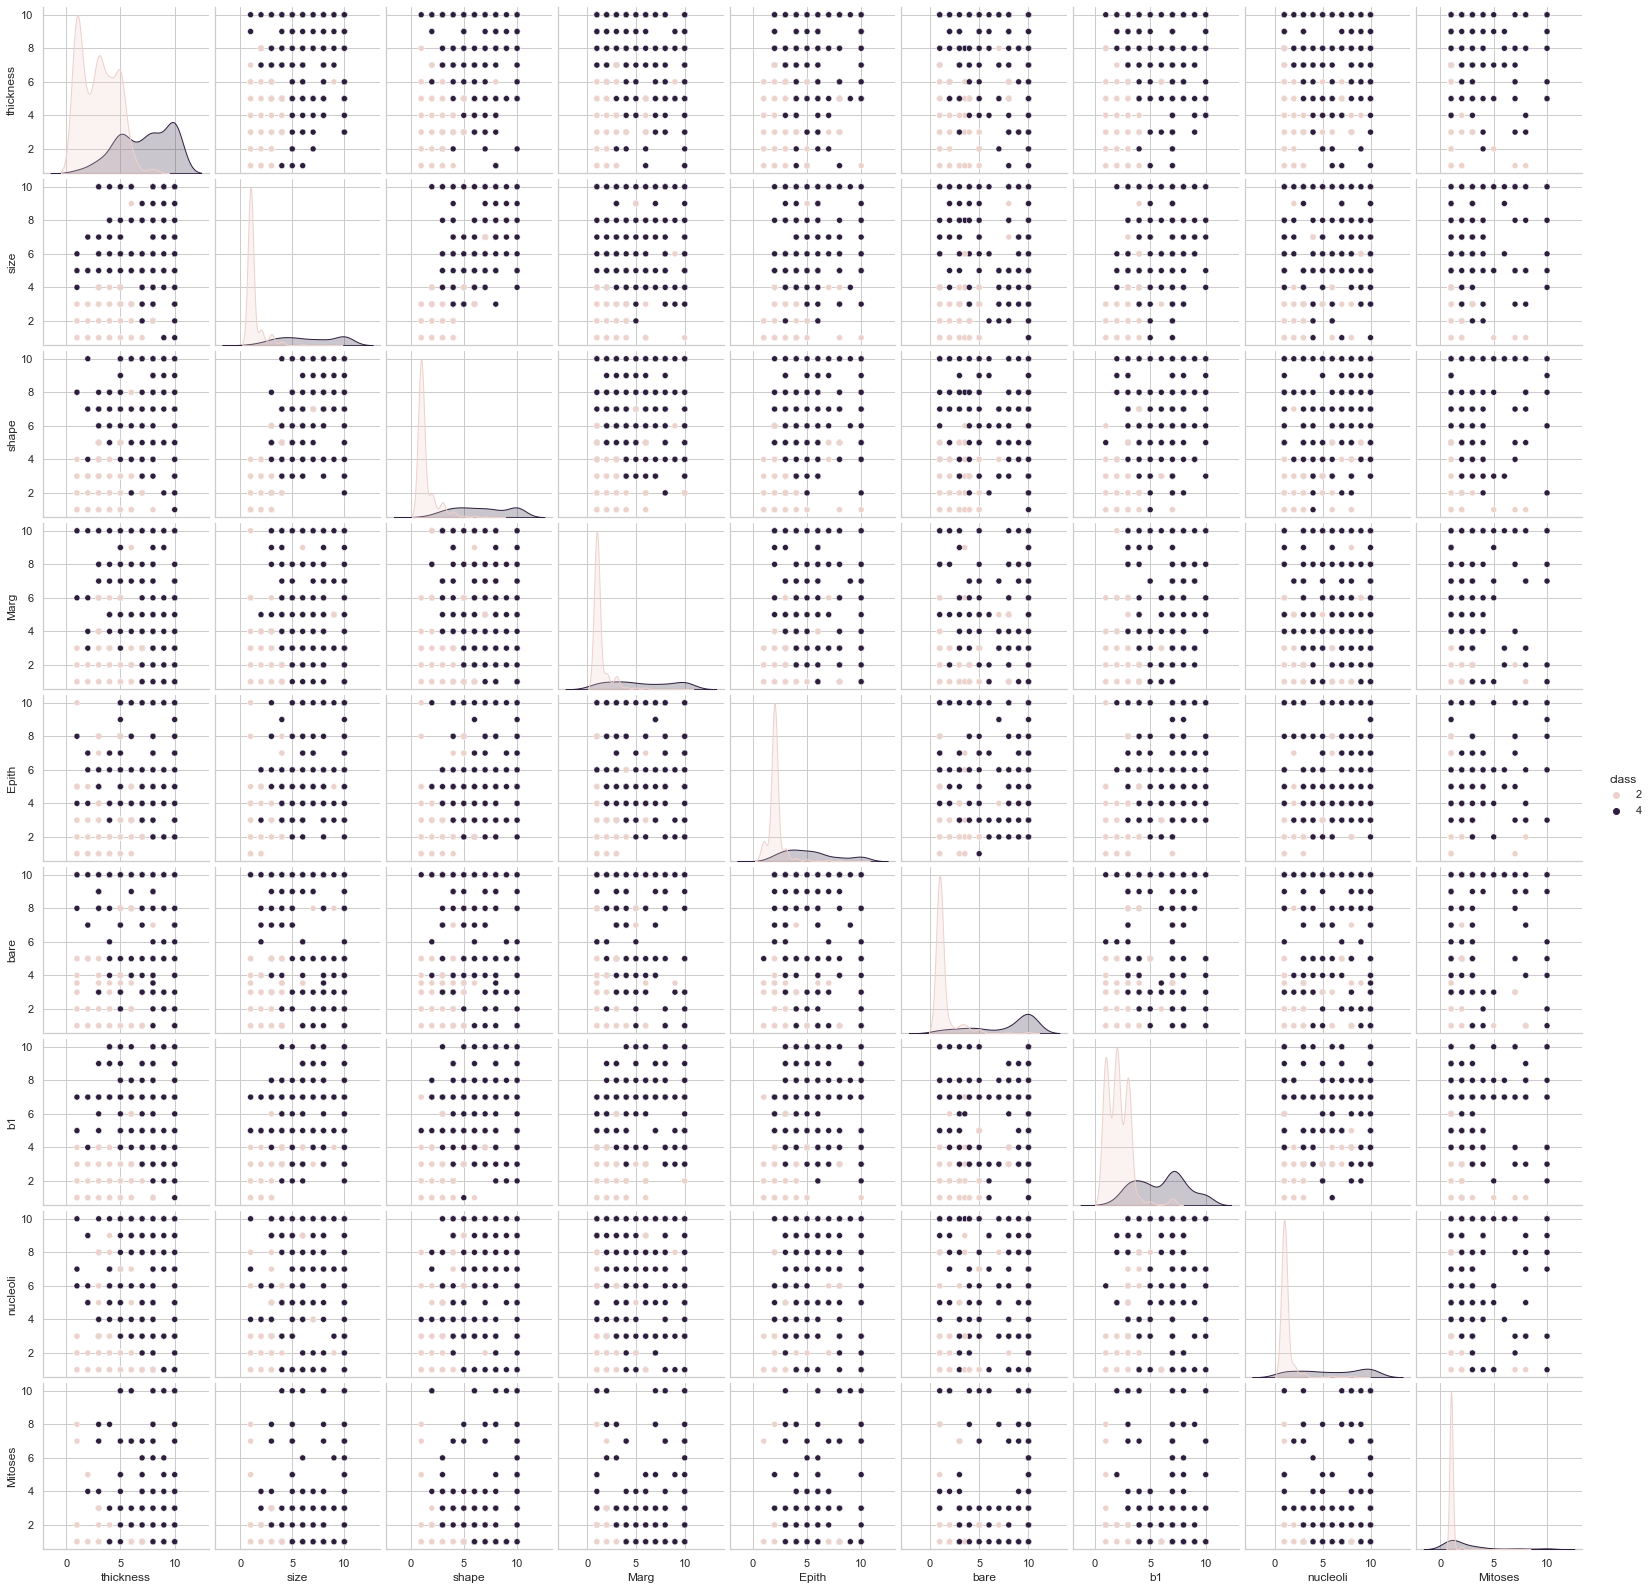

In [25]:
sns.pairplot(data_bruno, hue = 'class')
plt.show()

In [26]:
features = data_bruno[['thickness', 'size', 'shape',
                       'Marg', 'Epith', 'bare', 
                       'b1', 'nucleoli', 'Mitoses']].values
# scaled_features = StandardScaler().fit_transform(features)

In [27]:
reducer = umap.UMAP()

In [28]:
embedding = reducer.fit_transform(features)
embedding.shape

(699, 2)

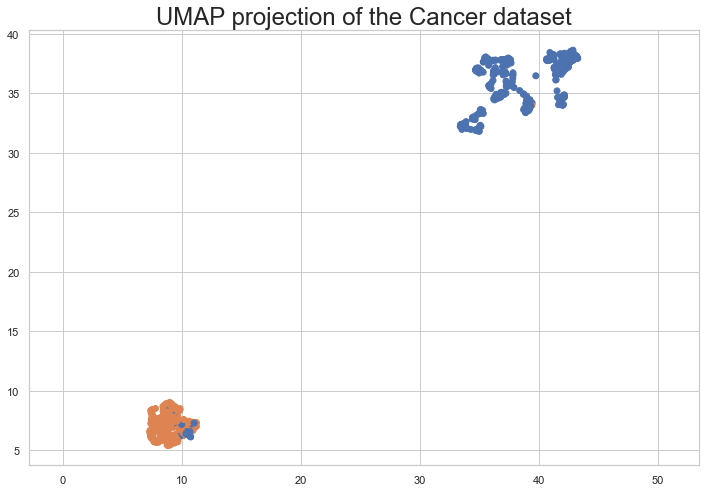

In [29]:
fig = plt.figure(figsize =[12,8])
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in data_bruno['class'].map({2:0, 4:1})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Cancer dataset', fontsize=24)
plt.show()

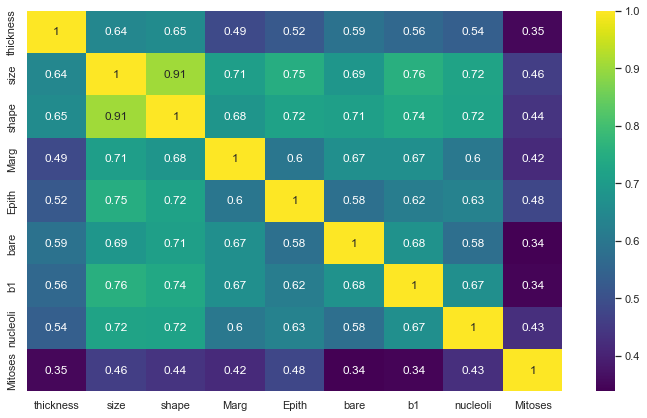

In [30]:
sns.heatmap(data_bruno.drop('class', axis = 1).corr(method = 'pearson'), annot = True, cmap = 'viridis')
plt.show()

In [31]:
# Separate features from target
X = data_bruno.drop('class', axis = 1)
y = data_bruno['class']

In [32]:
# Use train_test_split to generate Training and Test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=98)

In [33]:
# Instantiate the LInear Support Vector Classifier
clf_linear_bruno = SVC(kernel="linear", C=0.1)

In [34]:
# Fit the model onto the data
clf_linear_bruno.fit(X_train, y_train)

SVC(C=0.1, kernel='linear')

In [35]:
# Get the accuracy score in the training dataset
print(f'Trainning set accuracy: {np.round(clf_linear_bruno.score(X_train, y_train), 6) * 100}%')

Trainning set accuracy: 96.6011%


In [36]:
# Accuracy in the test dataset
print(f'Test set accuracy: {np.round(clf_linear_bruno.score(X_test, y_test), 6) * 100}%')

Test set accuracy: 99.2857%


`The linear model achieves an even higher accuracy in the test set.`

In [37]:
# Predictions using the test set
y_pred = clf_linear_bruno.predict(X_test)

In [38]:
# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

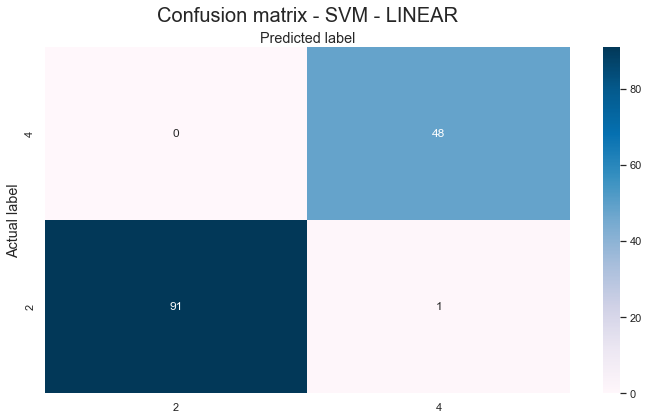

In [39]:
# A good visual of the confusion matrix
plot_confusion_matrix(cm, 'Linear', [0,2], 'PuBu')

In [40]:
print('\t\tClassification Report\n\n',classification_report(y_test, y_pred))

		Classification Report

               precision    recall  f1-score   support

           2       1.00      0.99      0.99        92
           4       0.98      1.00      0.99        48

    accuracy                           0.99       140
   macro avg       0.99      0.99      0.99       140
weighted avg       0.99      0.99      0.99       140



In [41]:
# %%javascript
# IPython.OutputArea.prototype._should_scroll = (lines) => {
#     return false;
# }

-------------------------------------------------------------------------------------------------------------------

RBF processing time: 0.004326 s

-------------------------------------------------------------------------------------------------------------------

RBF Training Accuracy score:  97.13770000000001%

RBF Test Accuracy score: 99.2857%


		Classification Report

               precision    recall  f1-score   support

           2       1.00      0.99      0.99        92
           4       0.98      1.00      0.99        48

    accuracy                           0.99       140
   macro avg       0.99      0.99      0.99       140
weighted avg       0.99      0.99      0.99       140

-------------------------------------------------------------------------------------------------------------------

POLY processing time: 0.003342 s

-------------------------------------------------------------------------------------------------------------------

POLY Training Accuracy sco

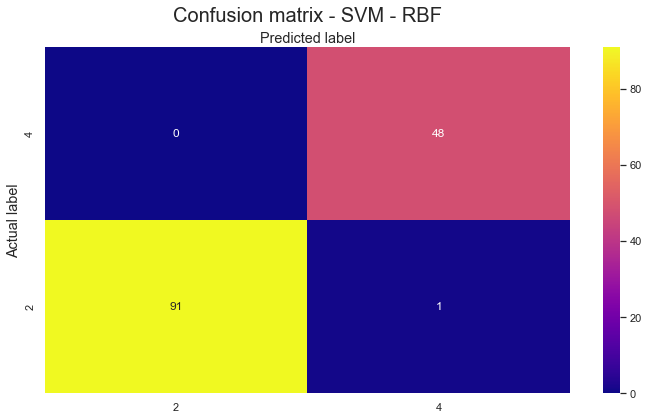

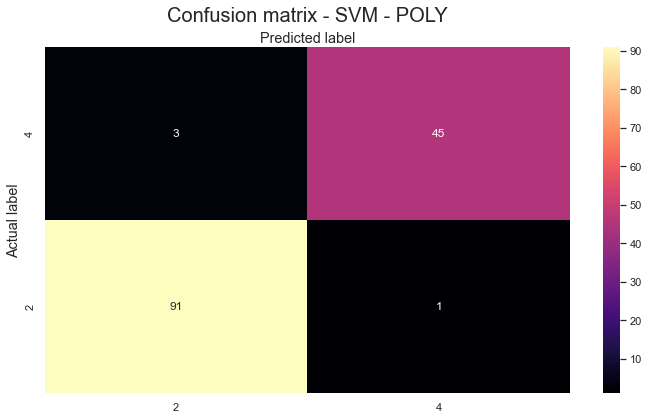

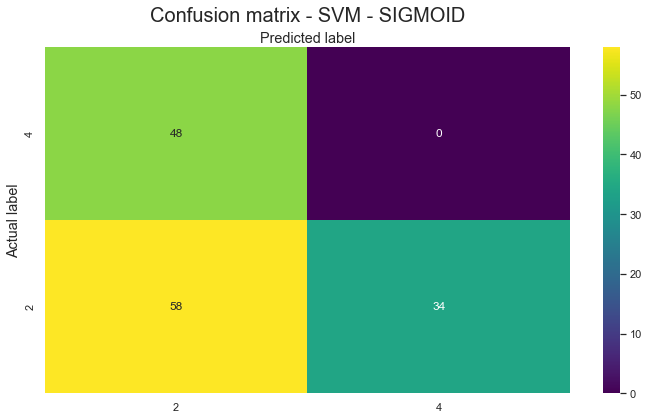

In [42]:
datasets = [X_train, y_train, X_test, y_test]
kernels = ['rbf', 'poly', 'sigmoid']
for kernel in kernels:
    test_classifier(kernel, datasets)

<hr></hr>

<div align="center" style='font-size:40px; padding:20px 0px'><strong> EXERCISE 2 </strong></div>

In [43]:
# Reloading the original dataset
data_bruno_df2 = pd.read_csv('breast_cancer.csv')

In [44]:
# Get the head of the reloaded dataset 
data_bruno_df2.head()

,ID,thickness,size,shape,Marg,Epith,bare,b1,nucleoli,Mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [45]:
data_bruno_df2['bare'].replace(to_replace = '?', value = np.nan, inplace = True)

In [46]:
data_bruno_df2['bare'] = data_bruno_df2['bare'].astype('float')

In [47]:
data_bruno_df2['bare'].dtype

dtype('float64')

In [48]:
data_bruno_df2.drop('ID', axis = 1, inplace = True)

In [49]:
X = data_bruno_df2.drop('class', axis = 1)
y = data_bruno_df2['class']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=98)

In [51]:
# Create a pipeline with transformers
num_pipeline_bruno = Pipeline([
('imputer', SimpleImputer(strategy="median")),
('std_scaler', StandardScaler()),
])

In [52]:
# A pipeline that calls upon the first pipeline and then the classifier
pipe_svm_bruno = Pipeline([
    ('numeric', num_pipeline_bruno),
    ('svm',  SVC(random_state = 98))
])

In [53]:
num_pipeline_bruno

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('std_scaler', StandardScaler())])

In [54]:
# Dictionary with parameters names (str) as keys and lists of parameter settings to try as values.
param_grid = {'svm__kernel': ['linear', 'rbf', 'poly'],
              'svm__C': [0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
              'svm__degree': [2, 3]}

In [55]:
param_grid

{'svm__kernel': ['linear', 'rbf', 'poly'],
 'svm__C': [0.01, 0.1, 1, 10, 100],
 'svm__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
 'svm__degree': [2, 3]}

In [56]:
# Create a GridSearchCV object
grid_search_bruno = GridSearchCV(estimator = pipe_svm_bruno,
                                 param_grid = param_grid,
                                 scoring = 'accuracy',
                                 refit = True,
                                 n_jobs = -1,
                                 verbose = 3)

In [57]:
# Inspect the object
grid_search_bruno

GridSearchCV(estimator=Pipeline(steps=[('numeric',
                                        Pipeline(steps=[('imputer',
                                                         SimpleImputer(strategy='median')),
                                                        ('std_scaler',
                                                         StandardScaler())])),
                                       ('svm', SVC(random_state=98))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.01, 0.1, 1, 10, 100],
                         'svm__degree': [2, 3],
                         'svm__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                         'svm__kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=3)

In [58]:
# Get the start time
start = time.perf_counter()

In [59]:
# Run fit with all sets of parameters
grid_search_bruno.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(estimator=Pipeline(steps=[('numeric',
                                        Pipeline(steps=[('imputer',
                                                         SimpleImputer(strategy='median')),
                                                        ('std_scaler',
                                                         StandardScaler())])),
                                       ('svm', SVC(random_state=98))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.01, 0.1, 1, 10, 100],
                         'svm__degree': [2, 3],
                         'svm__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                         'svm__kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=3)

In [60]:
# The the final time of processing
end = time.perf_counter()

In [61]:
# Total time to run GridSearchCV
print(f'GridSearchCV processing time: {round((end-start), 2)} s')

GridSearchCV processing time: 17.43 s


In [62]:
# Best hyperparameters
print("tuned hpyerparameters :(best parameters) ", grid_search_bruno.best_params_)
print("Best Estimator :", grid_search_bruno.best_estimator_)

tuned hpyerparameters :(best parameters)  {'svm__C': 0.1, 'svm__degree': 2, 'svm__gamma': 0.03, 'svm__kernel': 'rbf'}
Best Estimator : Pipeline(steps=[('numeric',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('std_scaler', StandardScaler())])),
                ('svm', SVC(C=0.1, degree=2, gamma=0.03, random_state=98))])


In [63]:
# Store the best model into a variable
best_model_bruno = grid_search_bruno.best_estimator_

In [64]:
# Inspect the object
best_model_bruno

Pipeline(steps=[('numeric',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('std_scaler', StandardScaler())])),
                ('svm', SVC(C=0.1, degree=2, gamma=0.03, random_state=98))])

In [65]:
# Make predictions with the best model
final_pred = best_model_bruno.predict(X_test)

In [66]:
# Accuracy in the test dataset
best_model_bruno.score(X_test, y_test)

0.9857142857142858

In [67]:
# Print the classification Report
print('\t\tClassification Report\n\n',classification_report(y_test, final_pred))

		Classification Report

               precision    recall  f1-score   support

           2       0.99      0.99      0.99        92
           4       0.98      0.98      0.98        48

    accuracy                           0.99       140
   macro avg       0.98      0.98      0.98       140
weighted avg       0.99      0.99      0.99       140



In [68]:
# Import joblib to save the model
import joblib

In [69]:
joblib.dump(best_model_bruno, "SVC_model.pkl")

['SVC_model.pkl']

In [70]:
joblib.dump(pipe_svm_bruno, "full_pipeline.pkl")

['full_pipeline.pkl']

In [71]:
# Use dill to create a copy of the whole notebook and its state
import dill

In [72]:
dill.dump_session('notebook_env.db')

[CV 3/5] END svm__C=0.01, svm__degree=2, svm__gamma=0.01, svm__kernel=rbf;, score=0.652 total time=   0.0s
[CV 3/5] END svm__C=0.01, svm__degree=2, svm__gamma=0.03, svm__kernel=poly;, score=0.652 total time=   0.0s
[CV 3/5] END svm__C=0.01, svm__degree=2, svm__gamma=0.1, svm__kernel=linear;, score=0.929 total time=   0.0s
[CV 1/5] END svm__C=0.01, svm__degree=2, svm__gamma=0.3, svm__kernel=linear;, score=0.955 total time=   0.0s
[CV 1/5] END svm__C=0.01, svm__degree=2, svm__gamma=0.3, svm__kernel=rbf;, score=0.652 total time=   0.0s
[CV 5/5] END svm__C=0.01, svm__degree=2, svm__gamma=1.0, svm__kernel=linear;, score=0.973 total time=   0.0s
[CV 5/5] END svm__C=0.01, svm__degree=2, svm__gamma=1.0, svm__kernel=rbf;, score=0.658 total time=   0.0s
[CV 1/5] END svm__C=0.01, svm__degree=3, svm__gamma=0.01, svm__kernel=linear;, score=0.955 total time=   0.0s
[CV 2/5] END svm__C=0.01, svm__degree=3, svm__gamma=0.01, svm__kernel=linear;, score=0.991 total time=   0.0s
[CV 5/5] END svm__C=0.01, 

[CV 2/5] END svm__C=0.01, svm__degree=2, svm__gamma=0.01, svm__kernel=rbf;, score=0.652 total time=   0.0s
[CV 5/5] END svm__C=0.01, svm__degree=2, svm__gamma=0.03, svm__kernel=linear;, score=0.973 total time=   0.0s
[CV 4/5] END svm__C=0.01, svm__degree=2, svm__gamma=0.03, svm__kernel=rbf;, score=0.839 total time=   0.1s
[CV 5/5] END svm__C=0.01, svm__degree=2, svm__gamma=0.1, svm__kernel=poly;, score=0.739 total time=   0.0s
[CV 4/5] END svm__C=0.01, svm__degree=2, svm__gamma=0.3, svm__kernel=rbf;, score=0.661 total time=   0.0s
[CV 4/5] END svm__C=0.01, svm__degree=3, svm__gamma=0.03, svm__kernel=poly;, score=0.661 total time=   0.0s
[CV 5/5] END svm__C=0.01, svm__degree=3, svm__gamma=0.03, svm__kernel=poly;, score=0.658 total time=   0.0s
[CV 4/5] END svm__C=0.01, svm__degree=3, svm__gamma=0.1, svm__kernel=rbf;, score=0.929 total time=   0.0s
[CV 5/5] END svm__C=0.01, svm__degree=3, svm__gamma=0.1, svm__kernel=rbf;, score=0.955 total time=   0.0s
[CV 2/5] END svm__C=0.01, svm__degr

[CV 2/5] END svm__C=0.01, svm__degree=2, svm__gamma=0.01, svm__kernel=poly;, score=0.652 total time=   0.0s
[CV 2/5] END svm__C=0.01, svm__degree=2, svm__gamma=0.03, svm__kernel=linear;, score=0.991 total time=   0.0s
[CV 2/5] END svm__C=0.01, svm__degree=2, svm__gamma=0.03, svm__kernel=rbf;, score=0.866 total time=   0.0s
[CV 1/5] END svm__C=0.01, svm__degree=2, svm__gamma=0.1, svm__kernel=poly;, score=0.688 total time=   0.1s
[CV 2/5] END svm__C=0.01, svm__degree=2, svm__gamma=1.0, svm__kernel=rbf;, score=0.652 total time=   0.0s
[CV 5/5] END svm__C=0.01, svm__degree=2, svm__gamma=3.0, svm__kernel=linear;, score=0.973 total time=   0.0s
[CV 2/5] END svm__C=0.01, svm__degree=2, svm__gamma=3.0, svm__kernel=poly;, score=0.955 total time=   0.0s
[CV 3/5] END svm__C=0.01, svm__degree=2, svm__gamma=3.0, svm__kernel=poly;, score=0.929 total time=   0.0s
[CV 1/5] END svm__C=0.01, svm__degree=3, svm__gamma=0.01, svm__kernel=poly;, score=0.652 total time=   0.0s
[CV 2/5] END svm__C=0.01, svm__

[CV 2/5] END svm__C=0.01, svm__degree=2, svm__gamma=0.01, svm__kernel=linear;, score=0.991 total time=   0.0s
[CV 5/5] END svm__C=0.01, svm__degree=2, svm__gamma=0.01, svm__kernel=poly;, score=0.658 total time=   0.0s
[CV 1/5] END svm__C=0.01, svm__degree=2, svm__gamma=0.1, svm__kernel=linear;, score=0.955 total time=   0.0s
[CV 5/5] END svm__C=0.01, svm__degree=2, svm__gamma=0.1, svm__kernel=linear;, score=0.973 total time=   0.0s
[CV 2/5] END svm__C=0.01, svm__degree=2, svm__gamma=0.3, svm__kernel=linear;, score=0.991 total time=   0.0s
[CV 3/5] END svm__C=0.01, svm__degree=2, svm__gamma=0.3, svm__kernel=rbf;, score=0.652 total time=   0.1s
[CV 2/5] END svm__C=0.01, svm__degree=2, svm__gamma=3.0, svm__kernel=linear;, score=0.991 total time=   0.0s
[CV 2/5] END svm__C=0.01, svm__degree=2, svm__gamma=3.0, svm__kernel=rbf;, score=0.652 total time=   0.0s
[CV 5/5] END svm__C=0.01, svm__degree=3, svm__gamma=0.01, svm__kernel=linear;, score=0.973 total time=   0.0s
[CV 1/5] END svm__C=0.01

<div align="center" style='font-size:40px; padding:20px 0px'><strong> END </strong></div>